In [1]:
#coding:utf-8

In [2]:
# 跟「繪圖」有關的套件，如果沒有打算繪圖就不用 import
%matplotlib inline
import seaborn as sn
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.utils import shuffle
drive.mount('/content/drive')
import math
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Input, LSTM, Dropout
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import gensim.downloader
from scipy.stats import gaussian_kde

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def show_train_history(train_history):

  #fig , ax = plt.subplots()
  #fig.subplots_adjust(hspace=0.4, wspace=0.4) #設定子圖的間隔
  #fig.set_figwidth(14)
  """
  ax1 = plt.subplot(1, 2, 1)
  plt.title("Accuracy")
  plt.plot(train_history.history['accuracy'],'-', label='accuracy')
  plt.plot(train_history.history['val_accuracy'],'-',  label='val_accuracy')
  leg = ax1.legend(loc='lower right') 
  plt.ylabel('accuracy')
  plt.xlabel('Epoch')
  """

  #ax2 = plt.subplot(1, 2, 2)
  plt.title("Loss")
  plt.plot(train_history.history['loss'],'-', label='loss')
  plt.plot(train_history.history['val_loss'],'-', label='val_loss')
  #leg = ax2.legend(loc='upper right') 
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.show()

In [4]:
data = pd.read_csv("/content/drive/MyDrive/DLPFLP/name,outline,totalFundedUSD.csv")
data = data.drop('country_code', axis=1)
data = data.drop('funding_rounds', axis=1)
data = data.drop('status', axis=1)
data = data.drop('entity_id', axis=1)
data = data.drop('normalized_name', axis=1)
data = data.dropna()
print(len(data))

drop_row = []
for rowIndex in range(len(data)):
  if data.iloc[rowIndex]['funding_total_usd'] == 0:
    if random.randint(1, 100) < 88:
      drop_row.append(rowIndex)

print(len(drop_row))
data = data.drop(data.index[drop_row])

print(data)

def usdLogged(x):
  if x < 10000:
    return 0
  else:
    return math.log(x, 10)

def normalize(x, max):
  if (x == 0):
    return 0
  else:
    return x / max

data['logged_funding_total_usd'] = data['funding_total_usd'].apply(lambda x:usdLogged(x))
max_logged_funding_total_usd = data['logged_funding_total_usd'].max()
# data['normalized_logged_funding_total_usd'] = data['logged_funding_total_usd'].apply(lambda x:normalize(x, max_logged_funding_total_usd))
# data['inverted_normalized_logged_funding_total_usd'] = data['normalized_logged_funding_total_usd'].apply(lambda x:1-x)
print(data['logged_funding_total_usd'].mean())

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


235235
180527
                                                 overview  funding_total_usd
0       Wetpaint is a technology platform company that...           39750000
2       There.com is an online virtual world where any...                  0
7       At HostNine they are commited to continually e...                  0
8       For more than a century, Thomas Publishing has...                  0
13      [FriendFeed](http://www.friendfeed.com) aims t...            5000000
...                                                   ...                ...
462525  ?Movirtu Share: Phone Numbers for the Un-Phone...                  0
462531  InstantWebVideos.Com is a new web-based servic...                  0
462566  First Posted on Lifehacker.com, by Jason FitzP...                  0
462617  TeamDesk is a web-based service that enables t...                  0
462634  Pintarget helps people to research online.  \n...                  0

[54708 rows x 2 columns]
3.1905755544296643


In [5]:
trainfundingTotalUsd = data['logged_funding_total_usd'].to_numpy()
trainOverviewString = data['overview'].to_numpy()
print(trainfundingTotalUsd)
print(trainfundingTotalUsd.shape)
print(trainOverviewString.shape)

[7.59933713 0.         0.         ... 0.         0.         0.        ]
(54708,)
(54708,)


In [6]:
def split_list(target_list:list, percent:float):
  return target_list[0:int(len(target_list) * percent)], target_list[int(len(target_list) * percent):int(len(target_list))]

In [7]:
print(trainfundingTotalUsd.shape)
print(trainOverviewString.shape)
trainOverviewString, trainfundingTotalUsd = shuffle(trainOverviewString, trainfundingTotalUsd)
trainfundingTotalUsd, testfundingTotalUsd = split_list(trainfundingTotalUsd, 0.8)
trainOverviewString, testOverviewString = split_list(trainOverviewString, 0.8)
print(trainfundingTotalUsd.shape)
print(trainfundingTotalUsd)
print(trainOverviewString.shape)
print(trainOverviewString)
print(testfundingTotalUsd.shape)
print(testfundingTotalUsd)
print(testOverviewString.shape)
print(testOverviewString)
print(sum(trainfundingTotalUsd) / len(trainfundingTotalUsd))
print(sum(testfundingTotalUsd) / len(testfundingTotalUsd))

(54708,)
(54708,)
(43766,)
[5.30103    0.         0.         ... 0.         6.21748394 5.76541893]
(43766,)
['Tidalwave Trader is an immersive learning modality for success in the stock market.  You will not find the same, nor as effective, way to ensure the highest state of knowledge possible in the stock market.\n\nThink of making all of your stock trading or investing thoughts, feelings, actions and results searchable and actionable and you have Tidalwave Trader.'
 "Casey Stenzel is directly responsible for the financial management, accounting and reporting of Direct Technology. In addition, he manages all corporate finance, acquisitions, financial forecasting and financial/risk management analysis. Casey joined Direct Technology in October 2012 after spending the majority of his career with Microsoft and Arthur Andersen LLP. With his 22 years of accounting, finance, and consulting experience in several companies and industries, Casey will be responsible for analyzing the financial 

In [8]:
print(trainfundingTotalUsd.min())

0.0


In [9]:
# 非必要，但用了會比較快
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(" Number of GPUs available: " , len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

 Number of GPUs available:  1


In [10]:
# pretrained word embedding
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [11]:
print(glove_vectors['hello'])

[-0.38497   0.80092   0.064106 -0.28355  -0.026759 -0.34532  -0.64253
 -0.11729  -0.33257   0.55243  -0.087813  0.9035    0.47102   0.56657
  0.6985   -0.35229  -0.86542   0.90573   0.03576  -0.071705 -0.12327
  0.54923   0.47005   0.35572   1.2611   -0.67581  -0.94983   0.68666
  0.3871   -1.3492    0.63512   0.46416  -0.48814   0.83827  -0.9246
 -0.33722   0.53741  -1.0616   -0.081403 -0.67111   0.30923  -0.3923
 -0.55002  -0.68827   0.58049  -0.11626   0.013139 -0.57654   0.048833
  0.67204 ]


In [12]:
for index in range(len(trainOverviewString)):
  trainOverviewString[index] = tf.keras.preprocessing.text.text_to_word_sequence(trainOverviewString[index])

for index in range(len(testOverviewString)):
  testOverviewString[index] = tf.keras.preprocessing.text.text_to_word_sequence(testOverviewString[index])



In [13]:
print(trainOverviewString[5])
print(testOverviewString[3])

['wazoo', 'sports', 'inc', 'is', 'a', 'high', 'school', 'sports', 'broadcast', 'network', 'with', 'offices', 'in', 'london', 'kentucky', 'knoxville', 'tennessee', 'and', 'benton', 'kentucky', 'wazoo', 'sports', 'delivers', 'live', 'coverage', 'of', 'high', 'school', 'sports', 'over', 'the', 'internet', 'using', 'the', 'latest', 'internet', 'broadcast', 'technology', 'their', 'coverage', 'is', 'professional', 'quality', 'using', 'multiple', 'cameras', 'a', 'director', 'and', 'broadcast', 'team']
['escapism', 'media', 'limited', 'provides', 'touch', 'screens', 'for', 'the', 'retail', 'and', 'hospitality', 'industry', 'its', 'touch', 'screens', 'are', 'embedded', 'into', 'tables', 'and', 'enable', 'customers', 'in', 'various', 'retail', 'hospitality', 'establishments', 'to', 'order', 'food', 'and', 'drinks', 'from', 'their', 'tables', 'send', 'messages', 'to', 'other', 'tables', 'play', 'interactive', 'games', 'at', 'the', 'table', 'and', 'between', 'tables', 'order', 'a', 'taxi', 'home',

In [14]:
numpyTrainOverviewString = np.zeros((len(trainOverviewString), 50, 50), np.float32)

for stringIndex in range(len(trainOverviewString)):
  if len(trainOverviewString[stringIndex]) >= 50:
    for wordIndex in range(50):
      try:
        numpyTrainOverviewString[stringIndex][wordIndex] = glove_vectors[trainOverviewString[stringIndex][wordIndex]].astype(np.float32)
      except KeyError:
        pass
  else:
    for wordIndex in range(len(trainOverviewString[stringIndex])):
      try:
        numpyTrainOverviewString[stringIndex][wordIndex] = glove_vectors[trainOverviewString[stringIndex][wordIndex]].astype(np.float32)
      except KeyError:
        pass

In [15]:
print(len(numpyTrainOverviewString[5][0]))
print(trainOverviewString)
print(numpyTrainOverviewString[5])

50
[list(['tidalwave', 'trader', 'is', 'an', 'immersive', 'learning', 'modality', 'for', 'success', 'in', 'the', 'stock', 'market', 'you', 'will', 'not', 'find', 'the', 'same', 'nor', 'as', 'effective', 'way', 'to', 'ensure', 'the', 'highest', 'state', 'of', 'knowledge', 'possible', 'in', 'the', 'stock', 'market', 'think', 'of', 'making', 'all', 'of', 'your', 'stock', 'trading', 'or', 'investing', 'thoughts', 'feelings', 'actions', 'and', 'results', 'searchable', 'and', 'actionable', 'and', 'you', 'have', 'tidalwave', 'trader'])
 list(['casey', 'stenzel', 'is', 'directly', 'responsible', 'for', 'the', 'financial', 'management', 'accounting', 'and', 'reporting', 'of', 'direct', 'technology', 'in', 'addition', 'he', 'manages', 'all', 'corporate', 'finance', 'acquisitions', 'financial', 'forecasting', 'and', 'financial', 'risk', 'management', 'analysis', 'casey', 'joined', 'direct', 'technology', 'in', 'october', '2012', 'after', 'spending', 'the', 'majority', 'of', 'his', 'career', 'with

In [16]:
# del numpyTrainOverviewString

In [17]:
# self made tokenizer
# tokenizer = Tokenizer(lower=True, num_words=40000)
# tokenizer.fit_on_texts(trainOverviewString)

In [18]:
# trainOverviewString = tokenizer.texts_to_sequences(trainOverviewString)
# print(trainOverviewString[20909])

In [19]:
# trainOverviewString = pad_sequences(trainOverviewString, padding='post', maxlen=100)
# print(trainOverviewString[10])
# print(trainOverviewString.shape)

In [20]:
# num_words = len(tokenizer.word_index) + 1
# print(num_words)

In [21]:
model = Sequential([
  # Embedding(input_dim=40000, output_dim=16, mask_zero=True),

  LSTM(512, input_length=50, input_dim=50),
  Dropout(0.2),
  Dense(512, activation='relu'),
  Dropout(0.2),
  Dense(256, activation='relu'),
  Dropout(0.2),
  Dense(128, activation='relu'),
  Dropout(0.2),
  Dense(64, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='linear')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1153024   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [23]:
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.00001, decay=0.0001))

In [24]:
# print(numpyTrainOverviewString)
print(trainfundingTotalUsd.max())

9.755874855672491


In [25]:
print(numpyTrainOverviewString.shape)
print(trainfundingTotalUsd.shape)
# train_history = model.fit(numpyTrainOverviewString, trainfundingTotalUsd, validation_split=0.2, batch_size=250, epochs=30)
train_history = model.fit(numpyTrainOverviewString, trainfundingTotalUsd, validation_split=0.2, batch_size=250, epochs=30, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


(43766, 50, 50)
(43766,)
Epoch 1/30
141/141 [==============================] - 10s 42ms/step - loss: 3.1949 - val_loss: 3.1482
Epoch 2/30
141/141 [==============================] - 5s 38ms/step - loss: 3.1510 - val_loss: 2.9790
Epoch 3/30
141/141 [==============================] - 5s 39ms/step - loss: 2.4620 - val_loss: 2.1780
Epoch 4/30
141/141 [==============================] - 5s 39ms/step - loss: 2.2787 - val_loss: 2.1123
Epoch 5/30
141/141 [==============================] - 6s 42ms/step - loss: 2.2156 - val_loss: 2.0560
Epoch 6/30
141/141 [==============================] - 5s 39ms/step - loss: 2.1538 - val_loss: 2.0824
Epoch 7/30
141/141 [==============================] - 5s 38ms/step - loss: 2.1222 - val_loss: 2.0081
Epoch 8/30
141/141 [==============================] - 5s 38ms/step - loss: 2.0914 - val_loss: 1.9863
Epoch 9/30
141/141 [==============================] - 5s 37ms/step - loss: 2.0799 - val_loss: 1.9901
Epoch 10/30
141/141 [==============================] - 5s 39ms/st

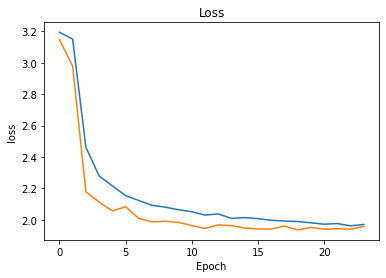

In [26]:
show_train_history(train_history)

In [27]:
# testOverviewString = tokenizer.texts_to_sequences(testOverviewString.tolist())
# print(testOverviewString)
# testOverviewString = pad_sequences(testOverviewString, padding='post', maxlen=100)
# print(testOverviewString)


In [28]:
# del numpyTrainOverviewString
numpyTestOverviewString = np.zeros((len(testOverviewString), 50, 50), np.float16)

for stringIndex in range(len(testOverviewString)):
  if len(testOverviewString[stringIndex]) >= 50:
    for wordIndex in range(50):
      try:
        numpyTestOverviewString[stringIndex][wordIndex] = glove_vectors[testOverviewString[stringIndex][wordIndex]].astype(np.float32)
      except KeyError:
        pass
  else:
    for wordIndex in range(len(testOverviewString[stringIndex])):
      try:
        numpyTestOverviewString[stringIndex][wordIndex] = glove_vectors[testOverviewString[stringIndex][wordIndex]].astype(np.float32)
      except KeyError:
        pass

In [29]:
predict = (model.predict(numpyTestOverviewString)).tolist()

print(predict)

342/342 [==============================] - 2s 4ms/step
[[3.5178709030151367], [2.3699305057525635], [0.005604855716228485], [4.302669525146484], [0.0012891737278550863], [5.198744297027588], [0.04446320980787277], [5.635665416717529], [0.0027263278607279062], [5.85523796081543], [6.110855579376221], [0.2703113555908203], [0.0017084034625440836], [2.9844768047332764], [5.132147312164307], [0.004365469329059124], [0.6918737888336182], [4.923102378845215], [6.438374042510986], [5.009005069732666], [4.774056911468506], [0.00221270602196455], [5.336300373077393], [5.136966228485107], [6.093868732452393], [5.700217247009277], [5.661501884460449], [0.002045285888016224], [0.002629196271300316], [0.0033203091006726027], [0.002147068502381444], [5.471146106719971], [5.890926361083984], [4.760241508483887], [0.0018970055971294641], [5.009036540985107], [0.769577145576477], [4.094903945922852], [4.137815475463867], [0.010072902776300907], [0.002909671515226364], [3.2858974933624268], [4.498841762

In [30]:
# print(np.array(predict).max())

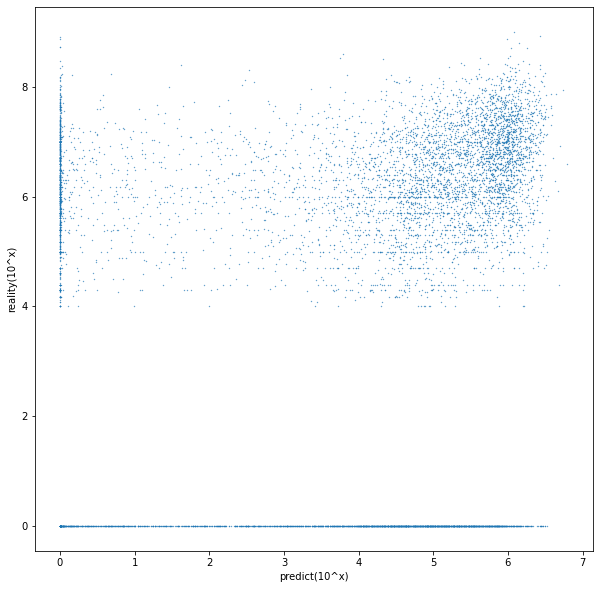

In [39]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.scatter(x=predict, y=testfundingTotalUsd,s=0.1)
plt.xlabel('predict(10^x)')
plt.ylabel('reality(10^x)')

plt.show()

In [42]:
model.save('my_model.h5')

[Text(69.0, 0.5, 'reality(10^x)'), Text(0.5, 42.0, 'predict(10^x)')]

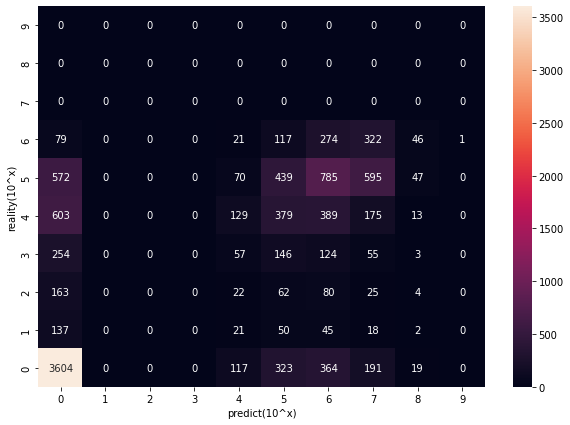

In [40]:
array = [[0,0,0,0,0,0,0,0,0,0], 
        [0,0,0,0,0,0,0,0,0,0],  
        [0,0,0,0,0,0,0,0,0,0],  
        [0,0,0,0,0,0,0,0,0,0], 
        [0,0,0,0,0,0,0,0,0,0],  
        [0,0,0,0,0,0,0,0,0,0], 
        [0,0,0,0,0,0,0,0,0,0], 
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],]

for index in range(len(predict)):
  # print(f"p:{predict[index][0]}, t:{testfundingTotalUsd[index]}")
  if (predict[index][0] > 9):
    predict[index][0] = 9
  elif (predict[index][0] < 0):
    predict[index][0] = 0

  if (testfundingTotalUsd[index] > 9):
    testfundingTotalUsd[index] = 9
  elif (testfundingTotalUsd[index] < 0):
    testfundingTotalUsd[index] = 0

  array[9 - math.floor(predict[index][0])][math.floor(testfundingTotalUsd[index])] += 1
  


df_cm = pd.DataFrame(array, index = [i for i in "9876543210"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True, fmt='d')
ax.set(xlabel='predict(10^x)', ylabel='reality(10^x)')